### Import Libraries

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

* `pandas` untuk manipulasi data
* `numpy` untuk melakukan perhitungan numerik
* `scipy.sparse` untuk membuat sparse matrix
* `sklearn.neighbors.NearestNeighbors` untuk algoritma KNN
* `sklearn.model_selection.train_test_split` untuk split data menjadi train dan test
* `sklearn.metrics` untuk metrik evaluasi
* `matplotlib.pyplot` untuk visualisasi data
* `seaborn` untuk plot statistik

### Read Data

In [2]:
file_name = 'dataset.csv' # membaca file CSV
column_title = ['userID', 'productID', 'rating', 'timestamp'] # memberi nama judul kolom
ds = pd.read_csv(file_name, names=column_title, header=None) # penerapan module pandas

ds # menampilkan baris dataset

,userID,productID,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
...,...,...,...,...
7824477,A2YZI3C9MOHC0L,BT008UKTMW,5.0,1396569600
7824478,A322MDK0M89RHN,BT008UKTMW,5.0,1313366400
7824479,A1MH90R0ADMIK0,BT008UKTMW,4.0,1404172800
7824480,A10M2KEFPEQDHN,BT008UKTMW,4.0,1297555200


### Data Cleaning

In [3]:
# memeriksa apakah ada data yang null
for column in ds.columns:
    # menghitung jumlah data null pada masing-masing kolom
    null_count = ds[column].isnull().sum() 
    if null_count > 0:
        print(f"Sejumlah data {null_count} pada kolom {column} akan dibersihkan")
        ds = ds.dropna() # drop baris yang null

print("Data sudah bersih")

Data sudah bersih


Pada dataset yang diberikan, data sudah bersih sehingga tidak memproses data cleaning

### Mengubah format timestamp menjadi yyyy-mm-dd

``unit='s'`` berarti data merupakan nilai detik (second) sebelum di-convert ke format datetime

In [4]:
ds['date'] = pd.to_datetime(ds['timestamp'], unit='s')

ds.head() # menampilkan beberapa baris teratas dari dataset

,userID,productID,rating,timestamp,date
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200,2013-04-13
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800,2012-07-01
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600,2013-04-29
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200,2013-07-22
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200,2012-04-18


### Mapping User dan Product

* ``enumerate`` berguna sebagai data index (auto increment)
* ``.unique()`` memastikan semua data berbeda
* ``DataFrame`` digunakan untuk menyusun data menjadi seperti tabel

In [6]:
# mapping user dan product
user_mapping = {user: index for index, user in enumerate(ds['userID'].unique())}
product_mapping = {product: index for index, product in enumerate(ds['productID'].unique())}

user_inverse_mapper = {index: user for user, index in user_mapping.items()}
product_inverse_mapper = {index: product for product, index in product_mapping.items()}

# membuat tampilan berupa hasil mapping dalam bentuk tabel
user_mapper_sample = pd.DataFrame(list(user_mapping.items()), columns=['UserID', 'Index'])
product_mapper_sample = pd.DataFrame(list(product_mapping.items()), columns=['ProductID', 'Index'])

# print sample
user_mapper_sample, product_mapper_sample

(                 UserID    Index
 0         AKM1MP6P0OYPR        0
 1        A2CX7LUOHB2NDG        1
 2        A2NWSAGRHCP8N5        2
 3        A2WNBOD3WNDNKT        3
 4        A1GI0U4ZRJA8WN        4
 ...                 ...      ...
 4201691   A5FUA9HEV2O42  4201691
 4201692   A84WRQR47OOKR  4201692
 4201693  A180UGKKYCPDH0  4201693
 4201694  A2IGIIABRZ5LAB  4201694
 4201695  A10M2KEFPEQDHN  4201695
 
 [4201696 rows x 2 columns],
          ProductID   Index
 0       0132793040       0
 1       0321732944       1
 2       0439886341       2
 3       0511189877       3
 4       0528881469       4
 ...            ...     ...
 475997  BT008G3W52  475997
 475998  BT008SXQ4C  475998
 475999  BT008T2BGK  475999
 476000  BT008UKTMW  476000
 476001  BT008V9J9U  476001
 
 [476002 rows x 2 columns])

### Mapping ID ke index

In [7]:
# mapping ID awal ke index yang sebelumnya dibuat
user_index = ds['userID'].map(user_mapping)
product_index = ds['productID'].map(product_mapping)

# menampilkan ID dalam index awal dan index setelah mapping
user_index_sample = user_index.head().reset_index()
user_index_sample.columns = ['Index Awal', 'Mapped Index']

product_index_sample = product_index.head().reset_index()
product_index_sample.columns = ['Index Awal', 'Mapped Index']

# menampilkan dalam bentuk tabel
user_index_sample, product_index_sample

(   Index Awal  Mapped Index
 0           0             0
 1           1             1
 2           2             2
 3           3             3
 4           4             4,
    Index Awal  Mapped Index
 0           0             0
 1           1             1
 2           2             2
 3           3             2
 4           4             2)

### Membuat Matrix Sparse

* matrix sparse ini merupakan hubungan rating dari user untuk suatu product
* output yang dihasilkan berupa tuple (baris, kolom) di mana baris merupakan jumlah user yang ada dalam data sedangkan kolom merupakan jumlah product yang ada dalam data

In [8]:
# membuat matrix sparse
# implementasi module scipy
sparse_matrix = csr_matrix((ds['rating'], (user_index, product_index)), shape=(len(user_mapping), len(product_mapping)))

# menampilkan length dari matriks sparse
sparse_matrix.shape

(4201696, 476002)

### Memisahkan data menjadi Data Train dan Data Test

* Karena dataset belum dipisah menjadi data test dan data train, maka kita hanya perlu menggunakan 20% data untuk dijadikan data test
* ``random_state`` merupakan tingkat randomness, pada proses ini saya menggunakan angka 53

In [9]:
# membagi data menjadi data train dan data test
data_train, data_test = train_test_split(ds, test_size=0.2, random_state=53)

# menampilkan length (baris, kolom) dari data train dan data test
data_train.shape, data_test.shape

((6259585, 5), (1564897, 5))

### Membuat Matrix Sparse untuk data train

In [10]:
# membuat matrix sparse untuk data train
train_user_index = data_train['userID'].map(user_mapping)
train_product_index = data_train['productID'].map(product_mapping)
train_sparse_matrix = csr_matrix((data_train['rating'], (train_user_index, train_product_index)), shape=(len(user_mapping), len(product_mapping)))

# menampilkan length matrix sparse untuk train
train_sparse_matrix.shape

(4201696, 476002)

### KNN Training

Pada proses ini, yang dilakukan adalah training algoritma KNN (K-Nearest Neightbours). Saya memilih algoritma KNN karena dengan mencari nearest neighbours, saya bisa mengetahui product yang paling mendekati product yang pernah dicari seorang user di masa lalu.

* ``metric`` merupakan parameter yang digunakan untuk mengukur kemiripan data yang diukur sedangkan ``consine`` merupakan implementasi dari consine similarity untuk mengukur kemiripan di mana semakin tinggi nilai consine-nya, semakin tinggi kemiripannya
* ``algorithm='brute'`` merupakan implementasi dari brute force search untuk menghitung jarak ke seluruh atau satu per satu data untuk menemukan nearest neighbour
* ``T`` akan transpose matrix 

In [11]:
# implementasi KNN dari module sklearn
knn = NearestNeighbors(metric='cosine', algorithm='brute')

# transpose matrix
knn.fit(train_sparse_matrix.T)

# Tampilkan pesan bahwa model telah selesai dilatih
print("KNN telah di-training")

KNN telah di-training


### Rekomendasi Produk

penjelasan parameter:
* ``user_id``: userID yang akan diberi rekomendasi
* ``sparse_matrix``: matrix yang menyimpan rating user terhadap suatu produk
* ``user_mapping``: mapping userID ke index dalam matrix space
* ``product_mapping``: mapping productID ke index dalam matrix space
* ``knn``: algoritma KNN yang sudah di-train
* ``ds``: dataset
* ``n_recommendation``: jumlah produk yang ingin direkomendasikan (saya menggunakan default 8 produk karena jika saya tidak menggunakan batas produk, akan memerlukan waktu yang banyak untuk mengeluarkan output nya)
* ``time_treshold``: batas waktu dari pembelian sebelumnya 

In [12]:
def recommend_products(user_id, sparse_matrix, user_mapping, product_mapping, product_inverse_mapper, knn, ds, n_recommendations=8, time_threshold=pd.Timestamp.now() - pd.Timedelta(days=365)):
    user_idx = user_mapping[user_id] # mencari index baris dalam matrix sparse
    # mendapatkan rating lalu mengubahnya menjadi array
    user_ratings = sparse_matrix[user_idx, :].toarray().flatten()
    rated_items = np.where(user_ratings > 0)[0] # mencari index product yang pernah di-rating
    
    recommendations = {}
    
    for item_idx in rated_items:
        distances, indices = knn.kneighbors(sparse_matrix.T[item_idx], n_neighbors=n_recommendations+1)
        # tidak mengambil yang pertama karena merupakan produk itu sendiri
        similar_items = indices.flatten()[1:] 
        similar_items_scores = distances.flatten()[1:]
        
        # mendapatkan timestamp pembelian terakhir untuk produk yang dibeli user
        user_item_timestamp = ds[(ds['userID'] == user_id) & (ds['productID'] == product_inverse_mapper[item_idx])]['date'].values[0]
        
        for similar_item_idx, score in zip(similar_items, similar_items_scores):
            similar_item = product_inverse_mapper[similar_item_idx]
            # jika belum ada, tambahkan ke dictionary (recommendation)
            if similar_item not in recommendations:
                recommendations[similar_item] = [score, user_item_timestamp]
            # jika sudah ada, tambahkan distance yang baru 
            else:
                recommendations[similar_item][0] += score
                recommendations[similar_item][1] = min(recommendations[similar_item][1], user_item_timestamp)
    
    # mengurutkan rekomendasi bersadasarkan kemiripan (semakin rendah score, semakin mirip) dan berdasarkan pembelian terakhir
    recommendations = sorted(recommendations.items(), key=lambda x: (x[1][0], -pd.Timestamp(x[1][1]).timestamp()), reverse=True)
    
    recommendations = recommendations[:n_recommendations]
    filtered_recommendations = [item for item in recommendations if item[1][1] > time_threshold]
    if not filtered_recommendations:
        filtered_recommendations = recommendations
    
    avg_ratings = {item[0]: ds[ds['productID'] == item[0]]['rating'].mean() for item in filtered_recommendations}
    
    return [(item[0], avg_ratings[item[0]]) for item in filtered_recommendations]

# Contoh penggunaan fungsi rekomendasi
user_id = 'A2BSSBK0B4FL26'
recommendations = recommend_products(user_id, train_sparse_matrix, user_mapping, product_mapping, product_inverse_mapper, knn, data_train)
print(recommendations)

[('B005XGQJY2', 4.5), ('B003H9M9B4', 5.0), ('B00CRMWOLC', 4.0), ('B00BWK57KA', 3.5), ('B000OKFD1W', 5.0), ('B000050ZZG', 5.0), ('B00B5I7P36', 5.0), ('B000E392XY', 5.0)]


### Visualisasi Data

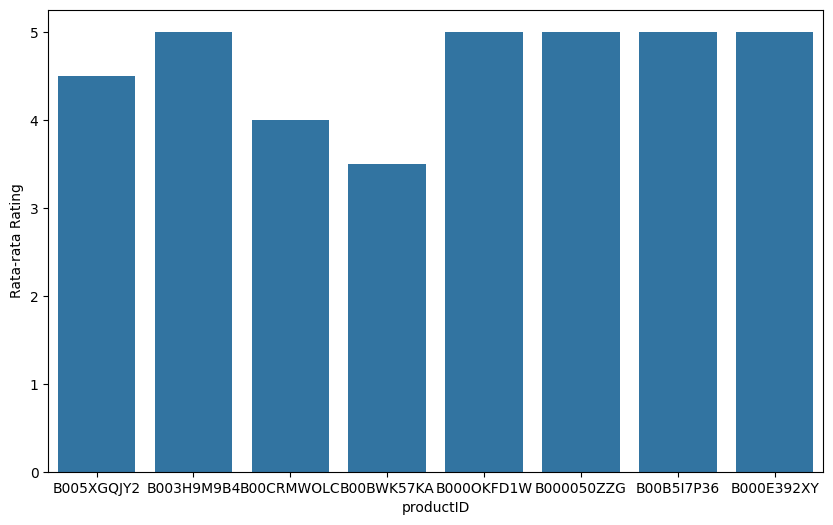

In [13]:
def visualize_recommendations(recommendations):
    if not recommendations:
        print("No recommendations to display.")
        return
    
    product_ids, avg_ratings = zip(*recommendations)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(product_ids), y=list(avg_ratings))
    plt.xlabel('productID')
    plt.ylabel('Rata-rata Rating')
    # plt.title('Recommended Products and Their Average Ratings')
    plt.show()

visualize_recommendations(recommendations)


In [13]:
def evaluate_model(data_test, train_sparse_matrix, user_mapping, product_mapping, product_inverse_mapper, knn, ds, k=8):
    y_true = []
    y_pred = []
    
    for _, row in data_test.iterrows():
        user_id = row['userID']
        actual_product_id = row['productID']
        
        if user_id in user_mapping and actual_product_id in product_mapping:
            recommendations = recommend_products(user_id, train_sparse_matrix, user_mapping, product_mapping, product_inverse_mapper, knn, ds, n_recommendations=k)
            recommended_product_ids = [rec[0] for rec in recommendations]
            
            y_true.append(1)
            y_pred.append(1 if actual_product_id in recommended_product_ids else 0)
    
    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy:", accuracy * 100, "%")

# Evaluasi model
evaluate_model(data_test, train_sparse_matrix, user_mapping, product_mapping, product_inverse_mapper, knn, data_train)
